In [2]:
import trackhhl.toy.simple_generator as toy
import trackhhl.event_model.q_event_model as em
import numpy as np
import itertools
import copy


### Detector Geometry

In [3]:
N_MODULES = 3
LX = float("+inf")
LY = float("+inf")
Z_SPACING = 1.0

detector = toy.SimpleDetectorGeometry(
    module_id=list(range(N_MODULES)),
    lx=[LX]*N_MODULES,
    ly=[LY]*N_MODULES,
    z=[i+Z_SPACING for i in range(N_MODULES)]
)

detector

SimpleDetectorGeometry(module_id=[0, 1, 2], lx=[inf, inf, inf], ly=[inf, inf, inf], z=[1.0, 2.0, 3.0])

### Particle Generator


In [4]:
generator = toy.SimpleGenerator(
    detector_geometry=detector,
    theta_max=np.pi/6
)
generator

SimpleGenerator(detector_geometry=SimpleDetectorGeometry(module_id=[0, 1, 2], lx=[inf, inf, inf], ly=[inf, inf, inf], z=[1.0, 2.0, 3.0]), primary_vertices=[], phi_min=0.0, phi_max=6.283185307179586, theta_min=0.0, theta_max=0.5235987755982988, rng=Generator(PCG64) at 0x1DE8CA67060)

In [5]:
N_PARTICLES = 3
event = generator.generate_event(N_PARTICLES)
event.hits

[Hit(hit_id=0, x=0.31423098766283397, y=0.14367874765050825, z=1.0, module_id=0, track_id=0),
 Hit(hit_id=3, x=-0.12177438925102792, y=-0.04049136859687949, z=1.0, module_id=0, track_id=1),
 Hit(hit_id=6, x=-0.07490840119699381, y=0.23331703415754468, z=1.0, module_id=0, track_id=2),
 Hit(hit_id=1, x=0.6284619753256679, y=0.2873574953010165, z=2.0, module_id=1, track_id=0),
 Hit(hit_id=4, x=-0.24354877850205583, y=-0.08098273719375898, z=2.0, module_id=1, track_id=1),
 Hit(hit_id=7, x=-0.14981680239398762, y=0.46663406831508936, z=2.0, module_id=1, track_id=2),
 Hit(hit_id=2, x=0.9426929629885019, y=0.43103624295152476, z=3.0, module_id=2, track_id=0),
 Hit(hit_id=5, x=-0.36532316775308377, y=-0.12147410579063847, z=3.0, module_id=2, track_id=1),
 Hit(hit_id=8, x=-0.22472520359098144, y=0.699951102472634, z=3.0, module_id=2, track_id=2)]

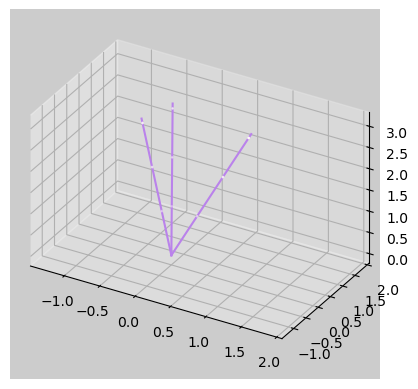

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
event.display(ax)
plt.show()

In [7]:
import numpy as np

#extract info from data:

positions = np.array([[hit.x, hit.y, hit.z] for hit in event.hits])
#whats up with the S matrix? do i get it somwhere, calculate it??
N_hits = len(event.hits)  # Total number of hits
epsilon = 0.01 #small small



def angular_term(S, epsilon, positions):
    H_angular = 0 #initialize
    N = len(S) #number of particles/nodes
    
    for a in range(N):   #iterate over all passible triplets of particles abc
        for b in range(N):
            for c in range(N):
                vec_ab = positions[b] - positions[a]  #vectorss that will be used to compute angles
                vec_bc = positions[c] - positions[b]
                norm_ab = np.linalg.norm(vec_ab)  #normsss
                norm_bc = np.linalg.norm(vec_bc)
                
                if norm_ab > 0 and norm_bc > 0: #enforce vectors having non-0 lengths
                    cos_theta_abc = np.dot(vec_ab, vec_bc) / (norm_ab * norm_bc) #angle between vectors
                    
                    if cos_theta_abc >= 1 - epsilon:
                        H_angular -= 0.5 * S[a, b] * S[b, c] #adds contribution to Hang if  the angle is small eough 

    return H_angular

def bifurcation_term(S):
    H_bifurcation = 0
    N = len(S)
    
    # First sum-fixed a
    for a in range(N):
        for b in range(N):
            for c in range(N):
                 H_bifurcation += S[a, b] * S[a, c]
    
    # Second sum-fixed b
    for b in range(N):
        for a in range(N):
            for c in range(N):
                H_bifurcation += S[a, b] * S[c, b]
    
    H_bifurcation *= 0.5 #1/2 devision
    
    return H_bifurcation

def occupancy_term(S, N_hits):
    
    total_sum = np.sum(S)
    difference = total_sum - N_hits
    H_occupancy = 0.5 * difference ** 2
    
    return H_occupancy

def total_hamiltonian(S, positions, N_hits, epsilon): #conjoin all the stuff
    H_ang = angular_term(S, epsilon, positions)
    H_bif = bifurcation_term(S)
    H_occ = occupancy_term(S, N_hits)

    H_total = H_ang + H_bif + H_occ
    return H_total

In [8]:
def generate_hamiltonian(event, params):
    lambda_val = params.get('lambda')
    alpha = params.get('alpha')
    beta = params.get('beta')

    modules = copy.deepcopy(event.modules)
    modules.sort(key=lambda a: a.z)

    segments = [em.segment(from_hit, to_hit) for idx in range(len(modules) - 1) for from_hit, to_hit in itertools.product(modules[idx].hits, modules[idx + 1].hits)]
    print(segments)
    N = len(segments)
    A = np.zeros((N, N))
    A_ang = np.zeros((N, N))
    A_bif = np.zeros((N, N))
    
    b = np.zeros(N)

    s_ab = np.zeros((N, N))
    for i, seg_i in enumerate(segments):
        for j, seg_j in enumerate(segments):
            s_ab[i, j] = int(seg_i.from_hit.module_id == 1 and seg_j.to_hit.module_id == 1)
    print(s_ab)
    A_inh = np.zeros((N, N))

    for i, seg_i in enumerate(segments):
        for j, seg_j in enumerate(segments):
            if i != j:
                vect_i = seg_i.to_vect()
                vect_j = seg_j.to_vect()
                cosine = np.dot(vect_i, vect_j) / (np.linalg.norm(vect_i) * np.linalg.norm(vect_j))

                eps = 1e-9

                if np.abs(cosine - 1) < eps:
                    A_ang[i, j] = 1

                if (seg_i.from_hit == seg_j.from_hit) and (seg_i.to_hit != seg_j.to_hit):
                    A_bif[i, j] = -alpha

                if (seg_i.from_hit != seg_j.from_hit) and (seg_i.to_hit == seg_j.to_hit):
                    A_bif[i, j] = -alpha

                A_inh[i, j] = s_ab[i, j] * s_ab[j, i] * beta

    # Compute the final expression
    A = -1 * (A_ang + A_bif + A_inh)

    components = {'A_ang': -A_ang, 'A_bif': -A_bif, 'A_inh': -A_inh}

    return A, b, components, segments

params = {
    'alpha': 1.0,
    'beta': 1.0,
    'lambda': 100.0,} 

A, b, _, _ = generate_hamiltonian(event, params)
print(A)

[segment(from_hit=Hit(hit_id=0, x=0.31423098766283397, y=0.14367874765050825, z=1.0, module_id=0, track_id=0), to_hit=Hit(hit_id=1, x=0.6284619753256679, y=0.2873574953010165, z=2.0, module_id=1, track_id=0), truth=True), segment(from_hit=Hit(hit_id=0, x=0.31423098766283397, y=0.14367874765050825, z=1.0, module_id=0, track_id=0), to_hit=Hit(hit_id=4, x=-0.24354877850205583, y=-0.08098273719375898, z=2.0, module_id=1, track_id=1), truth=False), segment(from_hit=Hit(hit_id=0, x=0.31423098766283397, y=0.14367874765050825, z=1.0, module_id=0, track_id=0), to_hit=Hit(hit_id=7, x=-0.14981680239398762, y=0.46663406831508936, z=2.0, module_id=1, track_id=2), truth=False), segment(from_hit=Hit(hit_id=3, x=-0.12177438925102792, y=-0.04049136859687949, z=1.0, module_id=0, track_id=1), to_hit=Hit(hit_id=1, x=0.6284619753256679, y=0.2873574953010165, z=2.0, module_id=1, track_id=0), truth=False), segment(from_hit=Hit(hit_id=3, x=-0.12177438925102792, y=-0.04049136859687949, z=1.0, module_id=0, trac

In [9]:
import dimod
from dwave.samplers import SimulatedAnnealingSampler

In [10]:
matrix_A = np.array(A)

def matrix_toQUBO(C):
    qubo = {}
    N = C.shape[0]
    for i in range(N):
        for j in range(N):
            qubo[(i, j)] = C[i, j]
    return qubo

qubo = matrix_toQUBO(matrix_A)

sampler = SimulatedAnnealingSampler()
response = sampler.sample_qubo(qubo, num_reads=100)

print("Results :")
print(response)

Results :
    0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 energy num_oc.
0   1  0  0  0  1  0  0  0  1  1  0  0  0  1  0  0  0  1   -6.0       1
1   1  0  0  0  1  0  0  0  1  1  0  0  0  1  0  0  0  1   -6.0       1
2   1  0  0  0  1  0  0  0  1  1  0  0  0  1  0  0  0  1   -6.0       1
3   1  0  0  0  1  0  0  0  1  1  0  0  0  1  0  0  0  1   -6.0       1
4   1  0  0  0  1  0  0  0  1  1  0  0  0  1  0  0  0  1   -6.0       1
5   1  0  0  0  1  0  0  0  1  1  0  0  0  1  0  0  0  1   -6.0       1
6   1  0  0  0  1  0  0  0  1  1  0  0  0  1  0  0  0  1   -6.0       1
7   1  0  0  0  1  0  0  0  1  1  0  0  0  1  0  0  0  1   -6.0       1
8   1  0  0  0  1  0  0  0  1  1  0  0  0  1  0  0  0  1   -6.0       1
9   1  0  0  0  1  0  0  0  1  1  0  0  0  1  0  0  0  1   -6.0       1
10  1  0  0  0  1  0  0  0  1  1  0  0  0  1  0  0  0  1   -6.0       1
11  1  0  0  0  1  0  0  0  1  1  0  0  0  1  0  0  0  1   -6.0       1
12  1  0  0  0  1  0  0  0  1  1  0  0  0  1  0  0  0 